# Anomaly Detection and Theft Modeling
## Non-Technical Loss Detection Pipeline

**Document Type:** Technical Analysis Report  
**Audience:** Data Scientists, ML Engineers, Model Reviewers  
**Prerequisites:** Complete notebooks 01 and 02; all artifacts must be generated  

---

### Objective

Train and calibrate detection models using a hybrid approach:
1. **Unsupervised (Isolation Forest):** Anomaly detection per customer cluster
2. **Supervised (XGBoost):** Classification using historical labels
3. **Ensemble scoring:** Combined probability with confidence weighting

### Outputs

- `artifacts/model_xgb.joblib` - Trained XGBoost classifier
- `artifacts/model_isolation_cluster_*.joblib` - Cluster-specific Isolation Forest models
- `artifacts/thresholds.json` - Calibrated detection thresholds
- `artifacts/metadata.json` - Model metadata and configuration

In [1]:
import sys
import json
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report, precision_recall_curve, auc,
    confusion_matrix, roc_auc_score
)
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd().parent
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'

print(f'Project Root: {PROJECT_ROOT}')
print(f'Execution Time: {datetime.now().isoformat()}')

Project Root: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein
Execution Time: 2025-12-16T02:47:51.030700


## 1. Load Preprocessed Data

In [2]:
# Load features with cluster assignments
features = pd.read_parquet(ARTIFACTS_DIR / 'preprocessed.parquet')

print('=== DATA LOADED ===')
print(f'Records: {len(features):,}')
print(f'Features: {len(features.columns)}')

# Identify feature columns
exclude_cols = ['CONS_NO', 'FLAG', 'quality_flag', 'cluster']
feature_cols = [c for c in features.columns if c not in exclude_cols]

print(f'Model features: {len(feature_cols)}')

# Check for labels
has_labels = 'FLAG' in features.columns and features['FLAG'].nunique() > 1
print(f'Labeled data available: {has_labels}')

if has_labels:
    print(f'Label distribution: {features["FLAG"].value_counts().to_dict()}')

=== DATA LOADED ===
Records: 25,863
Features: 48
Model features: 44
Labeled data available: True
Label distribution: {0: 23741, 1: 2122}


In [3]:
# Prepare modeling data
# Filter to high-quality records
if 'quality_flag' in features.columns:
    model_data = features[features['quality_flag'] == 'HIGH'].copy()
else:
    model_data = features.copy()

X = model_data[feature_cols].values.astype(np.float32)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

if has_labels:
    y = model_data['FLAG'].values

print(f'\nModeling data shape: {X.shape}')


Modeling data shape: (22142, 44)


## 2. Train/Test Split

Stratified split to preserve class balance across partitions.

In [4]:
if has_labels:
    # Stratified split: 60% train, 20% validation, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )
    
    print('=== DATA SPLIT ===')
    print(f'Training:   {len(X_train):,} samples (theft rate: {y_train.mean():.2%})')
    print(f'Validation: {len(X_val):,} samples (theft rate: {y_val.mean():.2%})')
    print(f'Test:       {len(X_test):,} samples (theft rate: {y_test.mean():.2%})')
else:
    X_train = X
    print('No labels available. Unsupervised methods only.')

=== DATA SPLIT ===
Training:   13,284 samples (theft rate: 8.53%)
Validation: 4,429 samples (theft rate: 8.53%)
Test:       4,429 samples (theft rate: 8.53%)


## 3. Unsupervised Detection: Isolation Forest

### Rationale

Isolation Forest is effective for anomaly detection because:
- Does not require labeled data
- Handles high-dimensional feature spaces
- Computationally efficient for large datasets

We train cluster-specific models to account for behavioral heterogeneity.

In [5]:
# Train Isolation Forest models per cluster
iso_models = {}

if 'cluster' in model_data.columns:
    clusters = model_data['cluster'].unique()
    clusters = [c for c in clusters if c >= 0]  # Exclude unassigned (-1)
else:
    clusters = [0]  # Single global model

print('=== ISOLATION FOREST TRAINING ===')

for cluster_id in clusters:
    if 'cluster' in model_data.columns:
        cluster_mask = model_data['cluster'] == cluster_id
        X_cluster = X[cluster_mask]
    else:
        X_cluster = X
    
    # Set contamination based on expected theft rate
    contamination = 0.1  # Conservative estimate
    
    iso_model = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    
    iso_model.fit(X_cluster)
    iso_models[cluster_id] = iso_model
    
    print(f'Cluster {cluster_id}: trained on {len(X_cluster):,} samples')

=== ISOLATION FOREST TRAINING ===
Cluster 3: trained on 6 samples
Cluster 2: trained on 11,935 samples
Cluster 0: trained on 10,200 samples
Cluster 1: trained on 1 samples


In [6]:
# Evaluate Isolation Forest (if labels available)
if has_labels:
    # Get anomaly scores for test set
    if 'cluster' in model_data.columns:
        test_clusters = model_data.iloc[len(X_train)+len(X_val):]['cluster'].values
    else:
        test_clusters = np.zeros(len(X_test))
    
    iso_scores = np.zeros(len(X_test))
    for i, (x, cluster_id) in enumerate(zip(X_test, test_clusters)):
        if cluster_id >= 0 and cluster_id in iso_models:
            iso_scores[i] = -iso_models[cluster_id].decision_function([x])[0]
        else:
            iso_scores[i] = 0
    
    # Convert to binary predictions using percentile threshold
    threshold = np.percentile(iso_scores, 90)
    iso_pred = (iso_scores > threshold).astype(int)
    
    print('\n=== ISOLATION FOREST EVALUATION ===')
    print(classification_report(y_test, iso_pred, target_names=['Normal', 'Theft']))


=== ISOLATION FOREST EVALUATION ===
              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92      4051
       Theft       0.19      0.22      0.20       378

    accuracy                           0.85      4429
   macro avg       0.56      0.57      0.56      4429
weighted avg       0.86      0.85      0.86      4429



## 4. Supervised Detection: XGBoost

### Rationale

XGBoost is selected for supervised learning because:
- Handles class imbalance via scale_pos_weight
- Provides feature importance for interpretability
- Robust to noisy features
- Fast inference for production deployment

In [7]:
if has_labels:
    # Calculate class weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    print('=== XGBOOST TRAINING ===')
    print(f'Scale positive weight: {scale_pos_weight:.2f}')
    
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr',
        early_stopping_rounds=20,
        use_label_encoder=False
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    print(f'Best iteration: {xgb_model.best_iteration}')
else:
    xgb_model = None
    print('Skipping XGBoost training: no labels available')

=== XGBOOST TRAINING ===
Scale positive weight: 10.72
Best iteration: 33


In [8]:
# Evaluate XGBoost
if xgb_model is not None:
    xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
    xgb_pred = (xgb_proba >= 0.5).astype(int)
    
    print('\n=== XGBOOST EVALUATION ===')
    print(classification_report(y_test, xgb_pred, target_names=['Normal', 'Theft']))
    
    # Calculate AUPRC
    precision, recall, _ = precision_recall_curve(y_test, xgb_proba)
    auprc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, xgb_proba)
    
    print(f'\nAUPRC: {auprc:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')


=== XGBOOST EVALUATION ===
              precision    recall  f1-score   support

      Normal       0.94      0.81      0.87      4051
       Theft       0.17      0.42      0.24       378

    accuracy                           0.77      4429
   macro avg       0.55      0.61      0.55      4429
weighted avg       0.87      0.77      0.81      4429


AUPRC: 0.2224
ROC-AUC: 0.6605



=== TOP 15 FEATURES BY IMPORTANCE ===
 1. consumption_max: 0.0740
 2. consumption_min: 0.0423
 3. rolling_3d_max_dev: 0.0392
 4. sudden_spike_count: 0.0385
 5. rolling_7d_mean_std: 0.0360
 6. normalized_std: 0.0306
 7. trough_to_avg_ratio: 0.0305
 8. consumption_entropy: 0.0295
 9. rolling_3d_mean_std: 0.0282
10. consumption_trend: 0.0268
11. rolling_14d_max_dev: 0.0264
12. rolling_7d_std_avg: 0.0254
13. consumption_p75: 0.0248
14. rolling_3d_std_avg: 0.0243
15. peak_to_avg_ratio: 0.0241


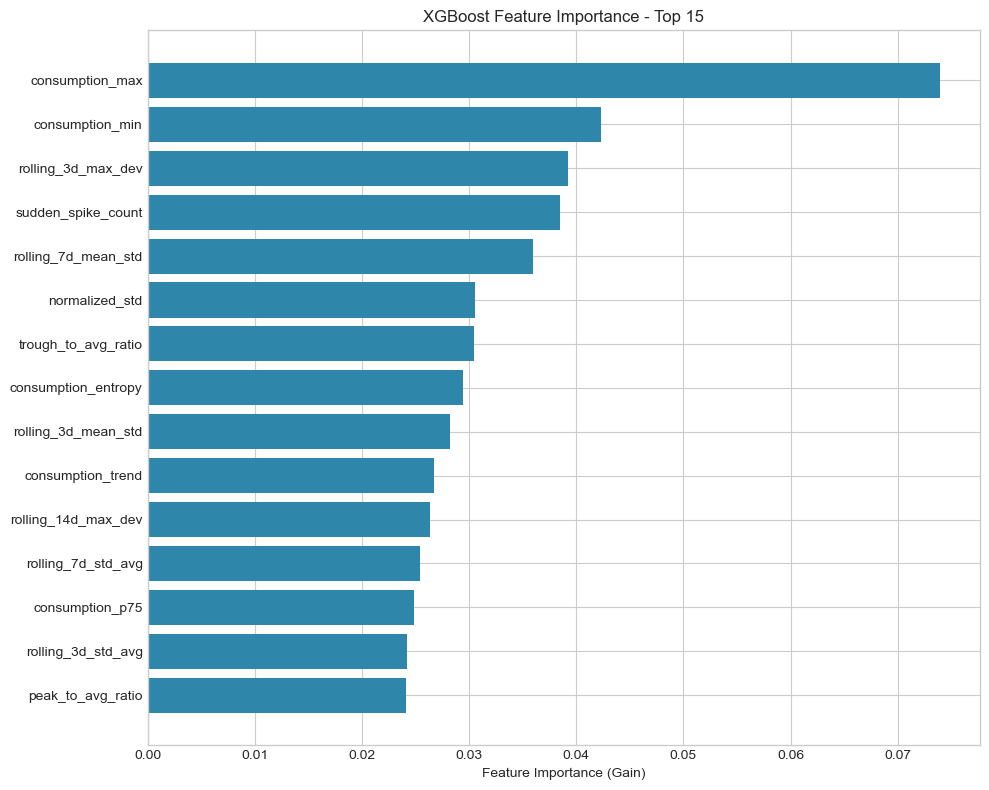


Figure saved: feature_importance.png


In [9]:
# Feature importance analysis
if xgb_model is not None:
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print('\n=== TOP 15 FEATURES BY IMPORTANCE ===')
    for i, (_, row) in enumerate(importance.head(15).iterrows(), 1):
        print(f'{i:2d}. {row["feature"]}: {row["importance"]:.4f}')
    
    # Visualize
    plt.figure(figsize=(10, 8))
    top_features = importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'].values[::-1], color='#2E86AB')
    plt.yticks(range(len(top_features)), top_features['feature'].values[::-1])
    plt.xlabel('Feature Importance (Gain)')
    plt.title('XGBoost Feature Importance - Top 15')
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print('\nFigure saved: feature_importance.png')

## 5. Threshold Calibration

### Objective

Calibrate thresholds to achieve target precision at operational capacity constraints.

For example, if investigation capacity allows reviewing top 2% of flagged customers:
- Target: Precision@2% > 60%
- Constraint: Monthly flags < 3,000 customers

In [10]:
if xgb_model is not None:
    # Calculate precision at various thresholds
    thresholds_to_test = [0.01, 0.02, 0.05, 0.10, 0.20]
    
    print('=== PRECISION@K ANALYSIS ===')
    print(f'{"k":>6} {"Precision":>12} {"Flagged":>12} {"True Positives":>15}')
    print('-' * 47)
    
    for k in thresholds_to_test:
        n_top = max(1, int(len(y_test) * k))
        top_indices = np.argsort(xgb_proba)[-n_top:]
        precision_at_k = y_test[top_indices].mean()
        true_positives = y_test[top_indices].sum()
        
        print(f'{k:>6.0%} {precision_at_k:>12.2%} {n_top:>12,} {true_positives:>15,}')
    
    # Determine operational threshold
    # Target: precision > 50% at manageable flag volume
    operational_threshold = np.percentile(xgb_proba, 95)  # Top 5%
    print(f'\nOperational threshold (95th percentile): {operational_threshold:.4f}')

=== PRECISION@K ANALYSIS ===
     k    Precision      Flagged  True Positives
-----------------------------------------------
    1%       52.27%           44              23
    2%       46.59%           88              41
    5%       31.67%          221              70
   10%       22.17%          442              98
   20%       17.40%          885             154

Operational threshold (95th percentile): 0.6453


## 6. Save Model Artifacts

In [11]:
# Save XGBoost model
if xgb_model is not None:
    joblib.dump(xgb_model, ARTIFACTS_DIR / 'model_xgb.joblib')
    print(f'Saved: {ARTIFACTS_DIR / "model_xgb.joblib"}')

# Save Isolation Forest models
for cluster_id, iso_model in iso_models.items():
    path = ARTIFACTS_DIR / f'model_isolation_cluster_{cluster_id}.joblib'
    joblib.dump(iso_model, path)
    print(f'Saved: {path}')

Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\model_xgb.joblib
Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\model_isolation_cluster_3.joblib
Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\model_isolation_cluster_2.joblib
Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\model_isolation_cluster_0.joblib
Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\model_isolation_cluster_1.joblib


In [12]:
# Save thresholds
thresholds = {
    'xgb_default': 0.5,
    'xgb_operational': float(operational_threshold) if xgb_model else 0.5,
    'isolation_percentile': 90,
    'high_risk': 0.8,
    'medium_risk': 0.5
}

with open(ARTIFACTS_DIR / 'thresholds.json', 'w') as f:
    json.dump(thresholds, f, indent=2)
print(f'Saved: {ARTIFACTS_DIR / "thresholds.json"}')

Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\thresholds.json


In [13]:
# Save model metadata
metadata = {
    'version': '1.0.0',
    'created_at': datetime.now().isoformat(),
    'pipeline_version': '1.0.0',
    'models': {
        'xgb': {
            'type': 'XGBClassifier',
            'n_estimators': 200,
            'max_depth': 6,
            'auprc': float(auprc) if xgb_model else None
        },
        'isolation_forest': {
            'type': 'IsolationForest',
            'n_clusters': len(iso_models),
            'contamination': 0.1
        }
    },
    'training': {
        'n_samples': len(X_train) if has_labels else len(X),
        'n_features': len(feature_cols),
        'theft_rate': float(y_train.mean()) if has_labels else None
    },
    'feature_names': feature_cols
}

with open(ARTIFACTS_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f'Saved: {ARTIFACTS_DIR / "metadata.json"}')

Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\metadata.json


In [14]:
# Summary
print('\n' + '='*60)
print('MODEL TRAINING SUMMARY')
print('='*60)
print(f'\nModels Trained:')
print(f'  - XGBoost Classifier: {"Yes" if xgb_model else "No (no labels)"}')
print(f'  - Isolation Forest: {len(iso_models)} cluster-specific models')
print(f'\nPerformance (Test Set):')
if xgb_model:
    print(f'  - AUPRC: {auprc:.4f}')
    print(f'  - ROC-AUC: {roc_auc:.4f}')
print(f'\nArtifacts:')
print(f'  - model_xgb.joblib')
for cluster_id in iso_models.keys():
    print(f'  - model_isolation_cluster_{cluster_id}.joblib')
print(f'  - thresholds.json')
print(f'  - metadata.json')
print('='*60)


MODEL TRAINING SUMMARY

Models Trained:
  - XGBoost Classifier: Yes
  - Isolation Forest: 4 cluster-specific models

Performance (Test Set):
  - AUPRC: 0.2224
  - ROC-AUC: 0.6605

Artifacts:
  - model_xgb.joblib
  - model_isolation_cluster_3.joblib
  - model_isolation_cluster_2.joblib
  - model_isolation_cluster_0.joblib
  - model_isolation_cluster_1.joblib
  - thresholds.json
  - metadata.json


---

**Next Step:** Proceed to 04_Evaluation_and_Risk_Analysis.ipynb